# Convolutional autoencoders

While we have implemented them, one convenience that we had through
the dataset was that each image has only 1 channel (each image was represented as a
black and white image) and the images are relatively small (28 x 28). Hence the
network flattened the input and was able to train on 784 (28*28) input values to
predict 784 output values. However, in reality, we will encounter images that have 3
channels and are much bigger than a 28 x 28 image.

In this section, we will learn about implementing a convolutional autoencoder that is
able to work on multi-dimensional input images. However, for the purpose of
comparison with vanilla autoencoders, we will work on the same MNIST dataset that
we worked on in the previous section, but modify the network in such a way that we
now build a convolutional autoencoder and not a vanilla autoencoder.

A convolutional autoencoder is represented as follows:

![imgs](./imgs/m0.png)

From the preceding image, we can see that the input image is represented as a block
in the bottleneck layer that is used to reconstruct the image. The image goes through
multiple convolutions to fetch the bottleneck representation (which is the <b> Bottleneck
layer </b> that is obtained by passing through <b> Encoder </b>) and the bottleneck representation
is up-scaled to fetch the original image (the original image is reconstructed by passing
through the <b> decoder </b>).



In [1]:
!pip install -q torch_snippets
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

trn_ds = MNIST('~/Data/mnist/', transform=img_transform, train=True, download=True)
val_ds = MNIST('~/Data/mnist/', transform=img_transform, train=False, download=True)

batch_size = 128
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

/home/lacie/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=3, padding=1), nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2), nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 5, stride=3, padding=1), nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 2, stride=2, padding=1), nn.Tanh()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
model = ConvAutoEncoder().to(device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 2, 2]            --
|    └─Conv2d: 2-1                       [-1, 32, 10, 10]          320
|    └─ReLU: 2-2                         [-1, 32, 10, 10]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 5, 5]            --
|    └─Conv2d: 2-4                       [-1, 64, 3, 3]            18,496
|    └─ReLU: 2-5                         [-1, 64, 3, 3]            --
|    └─MaxPool2d: 2-6                    [-1, 64, 2, 2]            --
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 5, 5]            18,464
|    └─ReLU: 2-8                         [-1, 32, 5, 5]            --
|    └─ConvTranspose2d: 2-9              [-1, 16, 15, 15]          12,816
|    └─ReLU: 2-10                        [-1, 16, 15, 15]          --
|    └─ConvTranspose2d: 2-11             [-1, 1, 28, 28]           65
| 

In [4]:
%pip install torch_summary

from torchsummary import summary
summary(model, torch.zeros(2,1,28,28))

Note: you may need to restart the kernel to use updated packages.
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 2, 2]            --
|    └─Conv2d: 2-1                       [-1, 32, 10, 10]          320
|    └─ReLU: 2-2                         [-1, 32, 10, 10]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 5, 5]            --
|    └─Conv2d: 2-4                       [-1, 64, 3, 3]            18,496
|    └─ReLU: 2-5                         [-1, 64, 3, 3]            --
|    └─MaxPool2d: 2-6                    [-1, 64, 2, 2]            --
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 5, 5]            18,464
|    └─ReLU: 2-8                         [-1, 32, 5, 5]            --
|    └─ConvTranspose2d: 2-9              [-1, 16, 15, 15]          12,816
|    └─ReLU: 2-10                        [-1, 16, 15, 15]          --
|    └

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 2, 2]            --
|    └─Conv2d: 2-1                       [-1, 32, 10, 10]          320
|    └─ReLU: 2-2                         [-1, 32, 10, 10]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 5, 5]            --
|    └─Conv2d: 2-4                       [-1, 64, 3, 3]            18,496
|    └─ReLU: 2-5                         [-1, 64, 3, 3]            --
|    └─MaxPool2d: 2-6                    [-1, 64, 2, 2]            --
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 5, 5]            18,464
|    └─ReLU: 2-8                         [-1, 32, 5, 5]            --
|    └─ConvTranspose2d: 2-9              [-1, 16, 15, 15]          12,816
|    └─ReLU: 2-10                        [-1, 16, 15, 15]          --
|    └─ConvTranspose2d: 2-11             [-1, 1, 28, 28]           65
| 

In [5]:
def train_batch(input, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    return loss

In [6]:
@torch.no_grad()
def validate_batch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

In [7]:
model = ConvAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

In [8]:
num_epochs = 5
log = Report(num_epochs)

for epoch in range(num_epochs):
    N = len(trn_dl)
    for ix, (data, _) in enumerate(trn_dl):
        loss = train_batch(data, model, criterion, optimizer)
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')
        
    N = len(val_dl)
    for ix, (data, _) in enumerate(val_dl):
        loss = validate_batch(data, model, criterion)
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
        
    log.report_avgs(epoch+1)

EPOCH: 1.000  trn_loss: 0.186  val_loss: 0.100  (4.78s - 19.12s remaining)
EPOCH: 2.000  trn_loss: 0.087  val_loss: 0.075  (9.39s - 14.09s remaining)
EPOCH: 3.000  trn_loss: 0.072  val_loss: 0.067  (14.02s - 9.34s remaining)
EPOCH: 4.000  trn_loss: 0.065  val_loss: 0.061  (18.63s - 4.66s remaining)
EPOCH: 5.000  trn_loss: 0.061  val_loss: 0.057  (23.14s - 0.00s remaining)


  0%|          | 0/106 [00:00<?, ?it/s]

100%|██████████| 106/106 [00:00<00:00, 5390.87it/s]


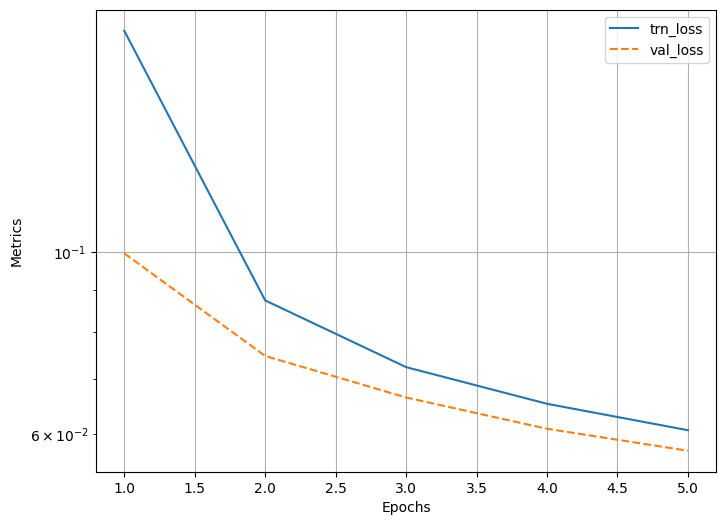

In [9]:
log.plot_epochs(log=True)

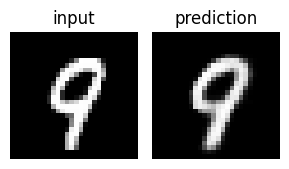

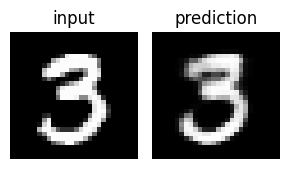

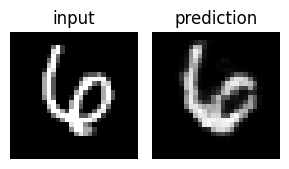

In [10]:
for _ in range(3):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    _im = model(im[None])[0]
    fig, ax = plt.subplots(1, 2, figsize=(3,3))
    show(im[0], ax=ax[0], title='input')
    show(_im[0], ax=ax[1], title='prediction')
    plt.tight_layout()
    plt.show()

# Grouping similar images using t-SNE

In [20]:
latent_vectors = []
classes = []

In [21]:
for im,clss in val_dl:
    latent_vectors.append(model.encoder(im).view(len(im),-1))
    classes.extend(clss)

In [24]:
latent_vectors = torch.cat(latent_vectors).cpu().detach().numpy()

In [22]:
from sklearn.manifold import TSNE
tsne = TSNE(2)

In [25]:
clustered = tsne.fit_transform(latent_vectors)

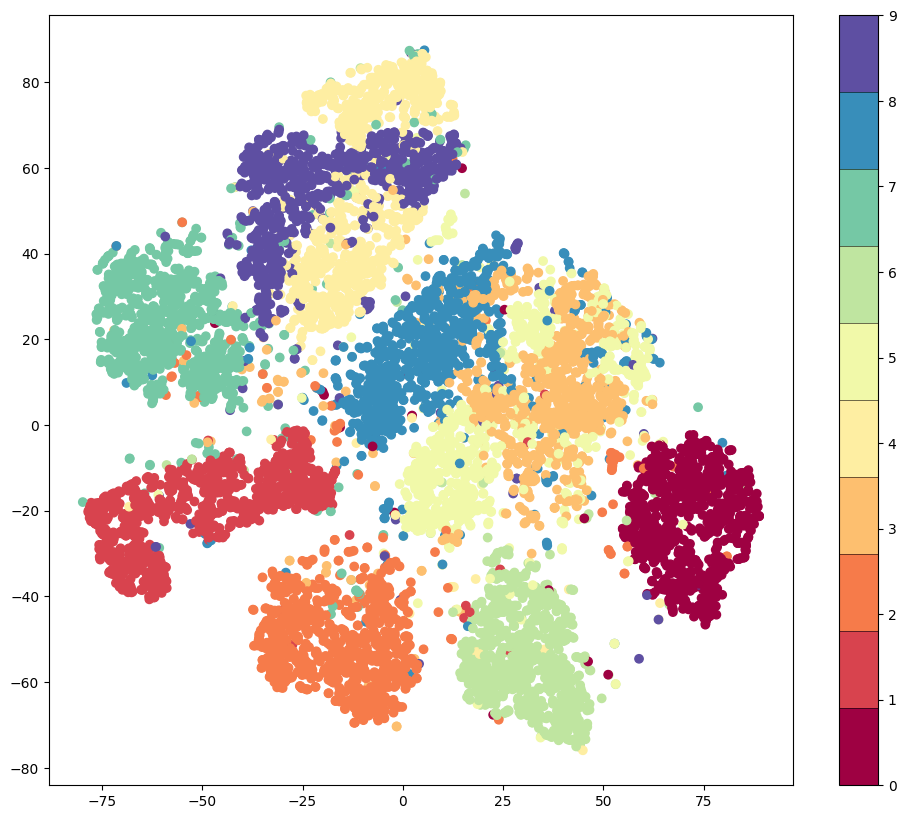

In [26]:
fig = plt.figure(figsize=(12,10))
cmap = plt.get_cmap('Spectral', 10)
plt.scatter(*zip(*clustered), c=classes, cmap=cmap)
plt.colorbar(drawedges=True)

In [27]:
latent_vectors = []
classes = []
for im,clss in val_dl:
    latent_vectors.append(model.encoder(im))
    classes.extend(clss)
latent_vectors = torch.cat(latent_vectors).cpu().detach().numpy().reshape(10000, -1)

In [28]:
rand_vectors = []
for col in latent_vectors.transpose(1,0):
    mu, sigma = col.mean(), col.std()
    rand_vectors.append(sigma*torch.randn(1,100) + mu)

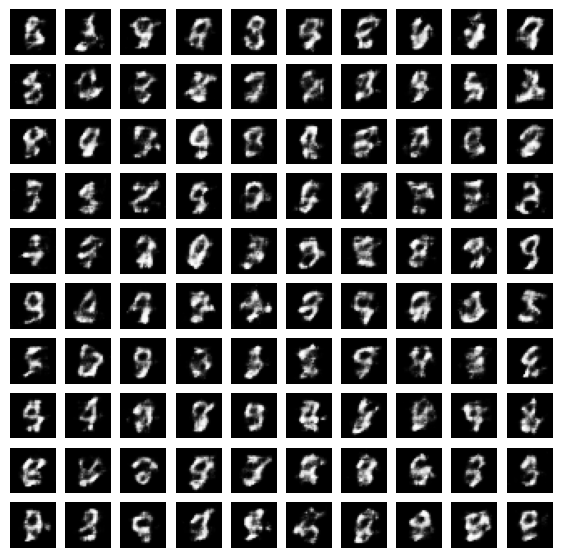

In [29]:
rand_vectors = torch.cat(rand_vectors).transpose(1,0).to(device)
fig, ax = plt.subplots(10,10,figsize=(7,7)); ax = iter(ax.flat)
for p in rand_vectors:
    img = model.decoder(p.reshape(1,64,2,2)).view(28,28)
    show(img, ax=next(ax))